In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [5]:
train_dir = "../train" #passing the path with training images
test_dir = "../test"   #passing the path with testing images

In [6]:
img_size = 48

In [7]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)



train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [8]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                                                         )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [9]:
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

In [10]:
len(train_generator)

359

In [11]:
X_train.shape

(64, 48, 48, 1)

In [12]:
y_train.shape

(64, 7)

In [13]:
X_test.shape

(64, 48, 48, 1)

In [14]:
y_test.shape

(64, 7)

In [15]:
class_names = train_generator.class_indices

class_names_swap = {v: k for k, v in class_names.items()}
print(class_names_swap)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


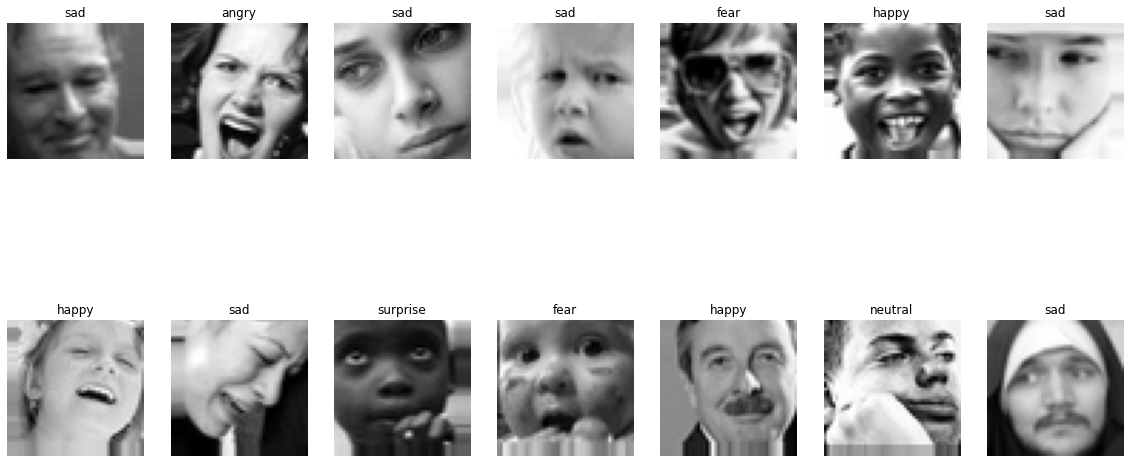

In [16]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np 

r = random.sample(range(X_train.shape[0]), 14)
for i in range(14):
    plt.subplot(2, 7, i+1)
    plt.imshow(X_train[r[i]],'gray')
    plt.title(class_names_swap[np.argmax(y_train[r[i]])])
    plt.axis("off")    

In [17]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))
# model.fit_generator(..., class_weight=train_class_weights)

In [18]:
train_class_weights

{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.826068191627104,
 5: 0.8491570541259982,
 6: 1.2933160650937552}

In [19]:
class_names_swap

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [20]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [21]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [22]:
def model_five(shape = (32, 32, 3), classes = 10):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = convolutional_block(x, 128)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = convolutional_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = convolutional_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "model_two")
    return model

In [23]:
model = model_five(shape = (48, 48, 1), classes = 7)

epochs = 200
batch_size = 64
model.summary()

Model: "model_two"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 27, 27, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 27, 27, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                               

                                                                                                  
 activation_8 (Activation)      (None, 7, 7, 128)    0           ['add_3[0][0]']                  
                                                                                                  
 dropout (Dropout)              (None, 7, 7, 128)    0           ['activation_8[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 7, 7, 128)    147584      ['dropout[0][0]']                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 7, 7, 128)   512         ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_18 (BatchN  (None, 7, 7, 128)   512         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_8 (Add)                    (None, 7, 7, 128)    0           ['batch_normalization_18[0][0]', 
                                                                  'activation_16[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 7, 7, 128)    0           ['add_8[0][0]']                  
                                                                                                  
 conv2d_20 (Conv2D)             (None, 4, 4, 256)    295168      ['activation_18[0][0]']          
          

 conv2d_29 (Conv2D)             (None, 4, 4, 256)    590080      ['dropout_3[0][0]']              
                                                                                                  
 batch_normalization_27 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_27 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_27[0][0]'] 
                                                                                                  
 conv2d_30 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_27[0][0]']          
                                                                                                  
 batch_normalization_28 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_30[0][0]']              
 ormalizat

                                                                  'activation_34[0][0]']          
                                                                                                  
 activation_36 (Activation)     (None, 4, 4, 256)    0           ['add_17[0][0]']                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_36[0][0]']          
                                                                                                  
 batch_normalization_37 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_37[0][0]'] 
          

 activation_45 (Activation)     (None, 2, 2, 512)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 2, 2, 512)    2359808     ['activation_45[0][0]']          
                                                                                                  
 batch_normalization_46 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_49[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_22 (Add)                   (None, 2, 2, 512)    0           ['batch_normalization_46[0][0]', 
                                                                  'dropout_6[0][0]']              
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_55 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_58[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 2, 2, 512)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 2, 2, 512)    2359808     ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_56 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_59[0][0]']              
 ormalization)                                                                                    
          

In [24]:
learning_rate = 0.001
decay_rate = learning_rate / 25
# momentum = 0.8
opt = Adam(lr=learning_rate,  decay=decay_rate)


model.compile(
    optimizer = opt, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    'fer-43.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [26]:
import scipy.integrate

import scipy.special
import scipy

history = model.fit(x = train_generator,epochs = epochs,batch_size=batch_size,validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/200
359/359 [==============================] - 125s 315ms/step - loss: 2.3424 - accuracy: 0.1253 - val_loss: 1.9578 - val_accuracy: 0.1180
Epoch 2/200
359/359 [==============================] - 113s 316ms/step - loss: 1.9412 - accuracy: 0.1452 - val_loss: 1.9226 - val_accuracy: 0.1613
Epoch 3/200
359/359 [==============================] - 115s 321ms/step - loss: 1.9126 - accuracy: 0.1941 - val_loss: 1.9274 - val_accuracy: 0.0559
Epoch 4/200
359/359 [==============================] - 116s 323ms/step - loss: 1.8852 - accuracy: 0.2006 - val_loss: 2.8569 - val_accuracy: 0.1257
Epoch 5/200
359/359 [==============================] - 117s 326ms/step - loss: 1.8714 - accuracy: 0.2335 - val_loss: 1.8814 - val_accuracy: 0.1781
Epoch 6/200
359/359 [==============================] - 117s 326ms/step - loss: 1.8738 - accuracy: 0.2022 - val_loss: 1.8781 - val_accuracy: 0.2263
Epoch 7/200
359/359 [==============================] - 117s 326ms/step - loss: 1.8374 - accuracy: 0.2129 - val_loss: 2

359/359 [==============================] - 116s 322ms/step - loss: 1.0195 - accuracy: 0.5750 - val_loss: 1.2598 - val_accuracy: 0.5314
Epoch 57/200
359/359 [==============================] - 116s 323ms/step - loss: 1.0219 - accuracy: 0.5785 - val_loss: 1.3126 - val_accuracy: 0.5237
Epoch 58/200
359/359 [==============================] - 116s 323ms/step - loss: 0.9996 - accuracy: 0.5846 - val_loss: 1.2066 - val_accuracy: 0.5426
Epoch 59/200
359/359 [==============================] - 116s 323ms/step - loss: 1.0043 - accuracy: 0.5830 - val_loss: 2.2344 - val_accuracy: 0.2486
Epoch 60/200
359/359 [==============================] - 116s 322ms/step - loss: 1.0090 - accuracy: 0.5843 - val_loss: 1.2058 - val_accuracy: 0.5475
Epoch 61/200
359/359 [==============================] - 116s 323ms/step - loss: 0.9784 - accuracy: 0.5961 - val_loss: 1.1895 - val_accuracy: 0.5552
Epoch 62/200
359/359 [==============================] - 116s 322ms/step - loss: 0.9683 - accuracy: 0.6008 - val_loss: 1.1481 

359/359 [==============================] - 116s 323ms/step - loss: 0.7183 - accuracy: 0.7056 - val_loss: 1.0352 - val_accuracy: 0.6306
Epoch 112/200
359/359 [==============================] - 116s 323ms/step - loss: 0.6949 - accuracy: 0.7096 - val_loss: 1.0907 - val_accuracy: 0.6180
Epoch 113/200
359/359 [==============================] - 116s 323ms/step - loss: 0.7029 - accuracy: 0.7127 - val_loss: 1.0811 - val_accuracy: 0.6117
Epoch 114/200
359/359 [==============================] - 116s 323ms/step - loss: 0.6919 - accuracy: 0.7159 - val_loss: 1.1142 - val_accuracy: 0.6117
Epoch 115/200
359/359 [==============================] - 115s 321ms/step - loss: 0.7067 - accuracy: 0.7081 - val_loss: 1.0771 - val_accuracy: 0.5999
Epoch 116/200
359/359 [==============================] - 116s 322ms/step - loss: 0.6942 - accuracy: 0.7113 - val_loss: 1.0348 - val_accuracy: 0.6299
Epoch 117/200
359/359 [==============================] - 116s 322ms/step - loss: 0.6885 - accuracy: 0.7163 - val_loss: 1

359/359 [==============================] - 116s 322ms/step - loss: 0.4811 - accuracy: 0.8058 - val_loss: 1.0960 - val_accuracy: 0.6341
Epoch 167/200
359/359 [==============================] - 115s 321ms/step - loss: 0.4921 - accuracy: 0.7976 - val_loss: 1.1087 - val_accuracy: 0.6208
Epoch 168/200
359/359 [==============================] - 116s 322ms/step - loss: 0.4885 - accuracy: 0.7990 - val_loss: 1.0978 - val_accuracy: 0.6348
Epoch 169/200
359/359 [==============================] - 116s 322ms/step - loss: 0.4799 - accuracy: 0.8019 - val_loss: 1.1427 - val_accuracy: 0.6138
Epoch 170/200
359/359 [==============================] - 115s 321ms/step - loss: 0.4923 - accuracy: 0.7962 - val_loss: 1.1527 - val_accuracy: 0.6215
Epoch 171/200
359/359 [==============================] - 116s 322ms/step - loss: 0.4968 - accuracy: 0.7980 - val_loss: 1.1202 - val_accuracy: 0.6299
Epoch 172/200
359/359 [==============================] - 116s 322ms/step - loss: 0.4807 - accuracy: 0.8002 - val_loss: 1

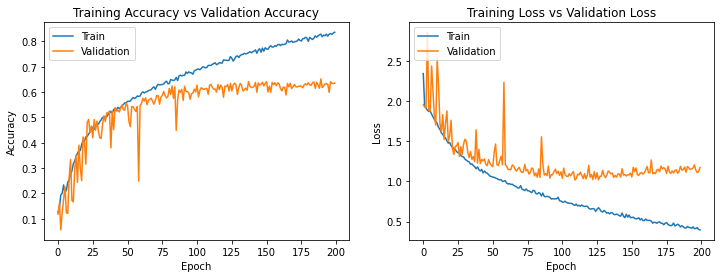

In [27]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [29]:
model.save('deeperdropout44_200_model.h5')
model.save_weights('deeperdropout44_200_weights.h5')

In [30]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 4s 157ms/step - loss: 1.1731 - accuracy: 0.6355
final train accuracy = 85.20 , validation accuracy = 63.55


23/23 [==============================] - 3s 84ms/step
Confusion Matrix
[[33  1 21 39 49 27 21]
 [ 3  0  5  6  3  4  1]
 [34  6 28 35 49 28 24]
 [56  5 41 81 86 45 40]
 [36  2 30 52 60 40 26]
 [50  1 28 50 57 38 25]
 [23  2 15 39 48 25 14]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.17      0.15       191
     disgust       0.00      0.00      0.00        22
        fear       0.17      0.14      0.15       204
       happy       0.27      0.23      0.25       354
     neutral       0.17      0.24      0.20       246
         sad       0.18      0.15      0.17       249
    surprise       0.09      0.08      0.09       166

    accuracy                           0.18      1432
   macro avg       0.15      0.15      0.14      1432
weighted avg       0.18      0.18      0.18      1432



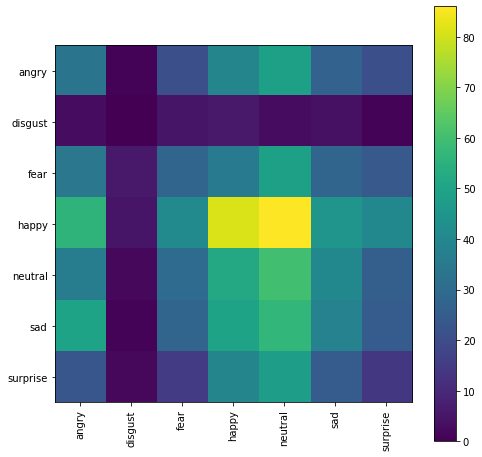

In [31]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

359/359 [==============================] - 28s 79ms/step
Confusion Matrix
[[ 467   57  402  732  730  459  349]
 [  48    5   53   84   75   49   35]
 [ 502   40  366  742  722  540  366]
 [ 824   96  733 1312 1305  860  642]
 [ 593   63  463  919  898  598  438]
 [ 535   59  491  926  856  565  432]
 [ 365   29  295  590  574  405  279]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.15      0.14      3196
     disgust       0.01      0.01      0.01       349
        fear       0.13      0.11      0.12      3278
       happy       0.25      0.23      0.24      5772
     neutral       0.17      0.23      0.20      3972
         sad       0.16      0.15      0.15      3864
    surprise       0.11      0.11      0.11      2537

    accuracy                           0.17     22968
   macro avg       0.14      0.14      0.14     22968
weighted avg       0.17      0.17      0.17     22968



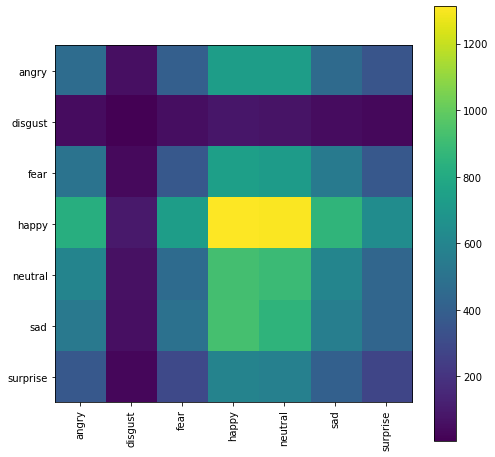

In [32]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)